# AutoAugment - Learning Augmentation Policies from Data

In this tutorial, we will be looking at how one can make use of [AutoAugment](https://arxiv.org/abs/1805.09501) as a data augmentation technique to train a neural net. 

We look at:
1. How can we use the `timm` training script to apply `AutoAugment`.
2. How can we use `AutoAugment` as a standalone data augmentation technique for custom training loops.
3. Take a deep-dive inside the source code of `AutoAugment`.

## `AutoAugment` using the `timm`'s training script

To train a model using the `timm`'s and apply auto augmentation data policy, simply add the `--aa` flag with a value of `'original'` or `'v1'` like so:

```python
python train.py ../imagenette2-320 --aa original
```

> NOTE: The "original" policy is the ImageNet policy from the [paper](https://arxiv.org/abs/1805.09501).

The above script trains a neural net using `AutoAugment` as an augmentation technique with the same policies as mentioned in the paper. 

## `AutoAugment` as a standalone data augmentation technique for custom training loops

In this section we will see how we can use `AutoAugment` as a standalone data augmentation technique in our own custom training loops.

We can simply create a transform function called `tfm` using the `auto_augment_transform` function in `timm`. We pass in a `config_str` and some `hparams` to the function to create our transform function. 

> NOTE: To apply `AutoAugment`, the transform function `tfm` created below expects the input to be an instance of `PIL.Image` and not a `torch.tensor`. Calling this function on a `torch.tensor` will cause an error. 

Below, we create our transformation function `tfm`, and also creat an input image `X` which is the image of a "tench" as used everywhere else in this documentation. 

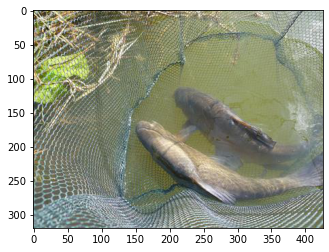

In [5]:
from timm.data.auto_augment import auto_augment_transform
from PIL import Image
from matplotlib import pyplot as plt

tfm = auto_augment_transform(config_str = 'original', hparams = {'translate_const': 100, 'img_mean': (124, 116, 104)})
X   = Image.open('../../imagenette2-320/train/n01440764/ILSVRC2012_val_00000293.JPEG')
plt.imshow(X);

Having visualized `X`, let's apply the transform function which applies the auto-augmentation policy to `X` and let's visualize the results below:

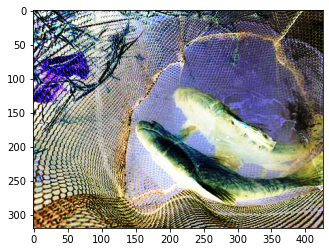

In [6]:
plt.imshow(tfm(X));

As we can see, the function `tfm` applies auto augmentation technique to the input image `X`. 

Thus, as long as we make sure that this function transforms an input image that is of type `PIL.Image`, we can use `timm` to apply `AutoAugment` in our custom training loops. 

## `timm`'s implementation of `AutoAugment`

Let's now take a deep dive to understand the `timm`'s implementation of `AutoAugment` policy. 

### `auto_augment_transform`

The complete source code of the `auto_augment_transform` that we used above looks like: 
    
```python
def auto_augment_transform(config_str, hparams):
    """
    Create a AutoAugment transform

    :param config_str: String defining configuration of auto augmentation. Consists of multiple sections separated by
    dashes ('-'). The first section defines the AutoAugment policy (one of 'v0', 'v0r', 'original', 'originalr').
    The remaining sections, not order sepecific determine
        'mstd' -  float std deviation of magnitude noise applied
    Ex 'original-mstd0.5' results in AutoAugment with original policy, magnitude_std 0.5

    :param hparams: Other hparams (kwargs) for the AutoAugmentation scheme

    :return: A PyTorch compatible Transform
    """
    config = config_str.split('-')
    policy_name = config[0]
    config = config[1:]
    for c in config:
        cs = re.split(r'(\d.*)', c)
        if len(cs) < 2:
            continue
        key, val = cs[:2]
        if key == 'mstd':
            # noise param injected via hparams for now
            hparams.setdefault('magnitude_std', float(val))
        else:
            assert False, 'Unknown AutoAugment config section'
    aa_policy = auto_augment_policy(policy_name, hparams=hparams)
    return AutoAugment(aa_policy)
```

This is very similar to [RandAugment](https://fastai.github.io/timmdocs/RandAugment)'s implementation. Basically, we pass in a config string, and based on the config string, this function sets up some `hparams` that then get passed to `auto_augment_policy` to create the policy. Finally we wrap this `aa_policy` around the `AutoAugment` class which get's returned to be applied to the input data. 

Let's take a look inside the `auto_augment_policy` and `AutoAugment` source code below. 

###  `auto_augment_policy` 

The source code of the `auto_augment_policy` function looks something like: 

```python
def auto_augment_policy(name='v0', hparams=None):
    hparams = hparams or _HPARAMS_DEFAULT
    if name == 'original':
        return auto_augment_policy_original(hparams)
```

Basically, this function accepts a policy name and then returns the corresponding augmentation policy. 

Let's take a look inside the `auto_augment_policy_original` function below.

### `auto_augment_policy_original` 

The source code of this function looks like: 

```python 
def auto_augment_policy_original(hparams):
    # ImageNet policy from https://arxiv.org/abs/1805.09501
    policy = [
        [('PosterizeOriginal', 0.4, 8), ('Rotate', 0.6, 9)],
        [('Solarize', 0.6, 5), ('AutoContrast', 0.6, 5)],
        [('Equalize', 0.8, 8), ('Equalize', 0.6, 3)],
        [('PosterizeOriginal', 0.6, 7), ('PosterizeOriginal', 0.6, 6)],
        [('Equalize', 0.4, 7), ('Solarize', 0.2, 4)],
        [('Equalize', 0.4, 4), ('Rotate', 0.8, 8)],
        [('Solarize', 0.6, 3), ('Equalize', 0.6, 7)],
        [('PosterizeOriginal', 0.8, 5), ('Equalize', 1.0, 2)],
        [('Rotate', 0.2, 3), ('Solarize', 0.6, 8)],
        [('Equalize', 0.6, 8), ('PosterizeOriginal', 0.4, 6)],
        [('Rotate', 0.8, 8), ('Color', 0.4, 0)],
        [('Rotate', 0.4, 9), ('Equalize', 0.6, 2)],
        [('Equalize', 0.0, 7), ('Equalize', 0.8, 8)],
        [('Invert', 0.6, 4), ('Equalize', 1.0, 8)],
        [('Color', 0.6, 4), ('Contrast', 1.0, 8)],
        [('Rotate', 0.8, 8), ('Color', 1.0, 2)],
        [('Color', 0.8, 8), ('Solarize', 0.8, 7)],
        [('Sharpness', 0.4, 7), ('Invert', 0.6, 8)],
        [('ShearX', 0.6, 5), ('Equalize', 1.0, 9)],
        [('Color', 0.4, 0), ('Equalize', 0.6, 3)],
        [('Equalize', 0.4, 7), ('Solarize', 0.2, 4)],
        [('Solarize', 0.6, 5), ('AutoContrast', 0.6, 5)],
        [('Invert', 0.6, 4), ('Equalize', 1.0, 8)],
        [('Color', 0.6, 4), ('Contrast', 1.0, 8)],
        [('Equalize', 0.8, 8), ('Equalize', 0.6, 3)],
    ]
    pc = [[AugmentOp(*a, hparams=hparams) for a in sp] for sp in policy]
    return pc
```

It's actually pretty simple the way `auto_augment_policy_original`has been constructed. As we know from the paper, the ImageNet policy consits of 25 sub policies. We iterate through the `policy` above to get a sub-policy `sp`. Finally we also iterate through each operation referred to as `a` in sub-policy `sp` and wrap it around the `AugmentOp` class. 

We have already looked into the `AugmentOp` class [here](https://fastai.github.io/timmdocs/RandAugment#AugmentOp).

Thus, in essence, each operation in the sub-policy get's converted to an instance of `AugmentOp` class based on the probability and magnitude values mentioned in the policy above. This becomes the policy that get's returned to create `aa_policy` in `auto_augment_transform`. 

## `AutoAugment`

As a last step in `auto_augment_transform` we wrap this `aa_policy` in `AutoAugment` class and that's what get's applied to the input data. So let's look into `AutoAugment` below:

```python
class AutoAugment:

    def __init__(self, policy):
        self.policy = policy

    def __call__(self, img):
        sub_policy = random.choice(self.policy)
        for op in sub_policy:
            img = op(img)
        return img
```

Really, this is one of the simplest implementations of `AutoAugment`. Similar to the paper, we select a random sub-policy, which consists of two operations (where each operation consists of an augmentation function, magnitude and probability of applying the augmentation function), and finally apply to these operations to the `img` to return the augmented image. 